In [59]:
using Random
using Statistics
using LinearAlgebra
using Plots
using Distributions
using GLM
using BenchmarkTools
using IJulia

In [19]:
T = 500
beta_0 = 1.0
beta_1 = 2.0
phi_x = 0.7
phi_u = 0.7
sigma = 1.0

1.0

In [20]:
function Simulate_ar1(n::Int, phi::Float64, sigma::Float64)
    errors = zeros(n)
    stdev = sqrt(sigma)
    eta = randn(n) * stdev
    for i in 2:n
        errors[i] = phi*errors[i-1] + eta[i]
    end 
    return errors
end

Simulate_ar1 (generic function with 1 method)

In [21]:
function Simulate_regression(n::Int, beta_0::Float64, beta_1::Float64, phi_x::Float64, phi_u::Float64, sigma::Float64)
    x = Simulate_ar1(n, phi_x, sigma)
    u = Simulate_ar1(n, phi_u, sigma)
    y = beta_0 .+ beta_1*x .+ u
    return y, x
end

Simulate_regression (generic function with 1 method)

In [22]:
function Moving_bb(y::Vector{Float64}, x::Vector{Float64}, block_length::Int, num_bootstrap::Int)
    T = length(y)
    num_blocks = div(T, block_length) + (T % block_length == 0 ? 0 : 1)
    
    X = hcat(ones(length(x)), x)
    #= original_model = lm(X, y)
    original_results = coef(original_model) =#
    
    bootstrap_estimates= zeros(num_bootstrap, 2)
    
    for i in 1:num_bootstrap
        bootstrap_sample_indices = Int[]
        while length(bootstrap_sample_indices) < T
            block_start = rand(1:T-block_length + 1)
            block_indices = block_start:(block_start + block_length - 1)
            append!(bootstrap_sample_indices, block_indices)
        end
        bootstrap_sample_indices = bootstrap_sample_indices[1:T]
        
        x_bootstrap = x[bootstrap_sample_indices]
        y_bootstrap = y[bootstrap_sample_indices]
        
        X_bootstrap = hcat(ones(length(x_bootstrap)), x_bootstrap)
        bootstrap_model = lm(X_bootstrap, y_bootstrap)
        bootstrap_estimates[i, :] .= coef(bootstrap_model)
    end
    
    bootstrap_se = std(bootstrap_estimates, dims=1)
    return bootstrap_se[2]
end

Moving_bb (generic function with 1 method)

In [23]:
function MonteCarlo_sim(se::Float64, num_simulations::Int)
    beta_1_ci = zeros(num_simulations)
    beta_1_e = []
    for i in 1:num_simulations
        y, x = Simulate_regression(T, beta_0, beta_1, phi_x, phi_u, sigma)
        X = hcat(ones(length(x)), x)
        model = lm(X, y)
        beta_1_hat = coef(model)[2]
        push!(beta_1_e, beta_1_hat)
        if (beta_1_hat - 1.96*se < beta_1 < beta_1_hat + 1.96*se)
            beta_1_ci[i] = 1
        end
    end
    println("The coverage probability is ", mean(beta_1_ci))
    histogram(beta_1_e, bins=100, alpha=0.5, normalize=:pdf, label="Empirical Distribution")
    xmin, xmax = extrema(beta_1_e)
    x = range(xmin, stop=xmax, length=100)
    p = pdf.(Normal(beta_1, 1/sqrt(T)), x)
    vline!([beta_1 - 1.96*se, beta_1 + 1.96*se], color=:red, linewidth=4, label="Confidence Interval")
    plot!(x, p, color=:black, linewidth=2, label="Normal Approximation")
end

MonteCarlo_sim (generic function with 1 method)

In [36]:
y, x = Simulate_regression(T, beta_0, beta_1, phi_x, phi_u, sigma)

SE = Moving_bb(y, x, 12, 1500)
println("The standard error for beta_1 is ", SE)
println("The confidence intereval at 95% for beta_1 is +- ", 1.96 * SE)


The standard error for beta_1 is 0.0607903312125178
The confidence intereval at 95% for beta_1 is +- 0.11914904917653488


The coverage probability is 0.9


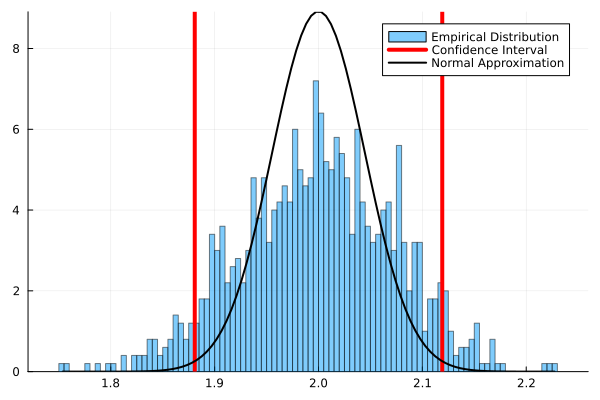

In [41]:
MonteCarlo_sim(SE, 1000)

The coverage probability is 0.883


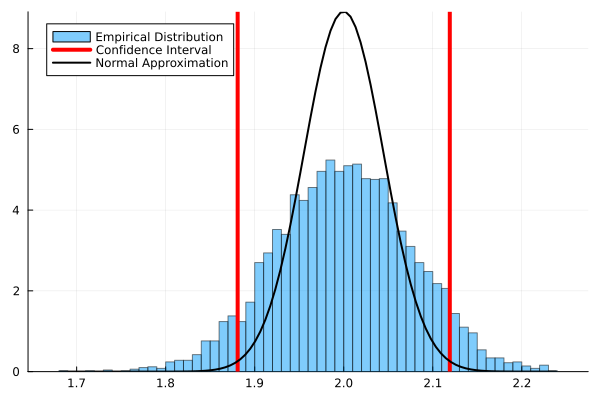

In [53]:
MonteCarlo_sim(SE, 5000)